# Inferencia Estadística
## Tarea 1

### Autor:
- [Sergio García Prado](https://garciparedes.me)

In [1]:
rm(list = ls())

In [2]:
library(magrittr)
library(IRdisplay, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(Bhat)
library(ggplot2)
library(reshape2)

In [3]:
options(repr.plot.width=12, repr.plot.height=6)

# Se lanzan seis monedas en cien ocasiones y se anota el número de caras en cada lanzamiento. Los resultados fueron:

In [4]:
coins <- data.frame(hits = c(0, 1, 2, 3, 4, 5, 6),
                    freq = c(2, 8, 10, 12, 16, 30, 22))

In [5]:
coins %>% 
    mutate_if(is.numeric, round, digits = 4) %>%
    mutate_all(as.character) %>%
    set_colnames(c('Número de caras', 'Frecuencias')) %>% 
    t() %>% 
    display()

Número de caras,0,1,2,3,4,5,6
Frecuencias,2,8,10,12,16,30,22


## Obtener el $pvalor$ del test de razón de verosimilitud para contrastar la siguiente hipótesis:
$$H_0: \text{Todas las monedas tienen la misma probabilidad de cara.}$$

Vamos a definir las siguientes variables aleatorias: 

$$Y_1,..., Y_6 \ iid \quad | \ Y_i \sim Bin(n, p_i)$$

Donde $n = 100$ es el número de realizaciones de la muestra, tal como se indica en el enunciado, y la variable $Y_i$ representa el *número de caras obtenidas por la moneda i-ésima*. Por tanto, el contraste se puede reescribir utilizando esta notación de tal manera que la hipótesis nula $H_0$ sea:
$$H_0: p_i = p_j \quad \forall i, j \in \{1,..., 6\}$$

Por la propiedad de independencia de las variables $Y_i$ entre si, podemos redefinir dicho test apoyándonos en:

$$X = \sum_{i = 1} ^ 6 Y_i$$

Donde $m = n \cdot 6 = 600$ y $p_0 = p_i \quad \forall i \in \{1, ..., 6\}$. Por lo tanto, podemos redefinir el contraste de tal manera que la hipótesis sea acerca del parámetro de una única distribución con parámetro $p_0$, que por independencia en el lanzamiento de monedas asumiremos como válido. Entonces la hipótesis nula se transforma en:

$$H_0: X \sim Bin(m, p_0)$$

Para contrastar esta hipótesis utilizaremos un *test de razón de verosimilitud*, para lo cual nos apoyaremos en la distribución multinomial.

Para ello, lo primero es calcular el número de observaciones:

In [6]:
m <- coins %>%
    summarise((max(hits) * sum(freq))) %>%
    pull()

In [7]:
display_latex(paste0('$$m = ', m, '$$'))

Puesto que vamos a realizar el test utilizando frecuencias relativas, es necesario calcular estas sobre los datos observados

In [8]:
coins <- coins %>%
    mutate(freq.rel = freq / sum(freq))

In [9]:
coins %>% 
    mutate_if(is.numeric, round, digits = 4) %>%
    mutate_all(as.character) %>%
    set_colnames(c('Número de caras', 'Frecuencias', 'Frecuencias Rel.')) %>% 
    t() %>% 
    display()

Número de caras,0,1,2,3,4,5,6
Frecuencias,2,8,10,12,16,30,22
Frecuencias Rel.,0.02,0.08,0.1,0.12,0.16,0.3,0.22


El siguiente paso es obtener el *Estimador Máximo Verosimil* bajo la hipótesis nula. Esto se puede hacer tanto de manera analítica, como de manera numérica a partir de la función `optim`.

Se puede comprobar fácilmente que el EMV para una distribución binomial se construye como $\hat{p}_0 = \frac{\sum x_i}{m}$, cuya varianza aproximada es $\widehat{Var}[\widehat{p}_0] = \frac{\widehat{p}_0 * (1 - \widehat{p}_0)}{m}$ . A continuación se calculan dichos valores:

In [10]:
p.zero.hat <- coins %>%
    mutate(total = freq * hits) %>%
    summarise(sum(total) / m) %>%
    pull()
p.zero.hat.var <- p.zero.hat * (1 - p.zero.hat) / m

In [11]:
display_latex(paste0('$$\\widehat{p}_0 = ', round(p.zero.hat, digits = 5), '\\quad',
                     '\\widehat{Var}[\\widehat{p}_0] = ', round(p.zero.hat.var, digits = 5), '$$'))

Sin embargo, en este caso vamos a optilizar el ajuste numérico a partir de la función `optim`. Para ello es necesario definir la función $-logL(p; x_1, ..., x_m)$.

In [12]:
loglhood <- function(p, y, m) {
    l <- y * log(p) + (m - y) * log(1 - p)
    return(l)
}
negative.loglhood <- function(p, y, m) {
    - loglhood(p, y, m)
}

A continuación se muestra la función $logL(p; x_1, ..., x_m)$. Es fácil apreciar que esta toma su valor máximo en torno a $p = 0.68$, tal y como hemos indicado anteriormente.

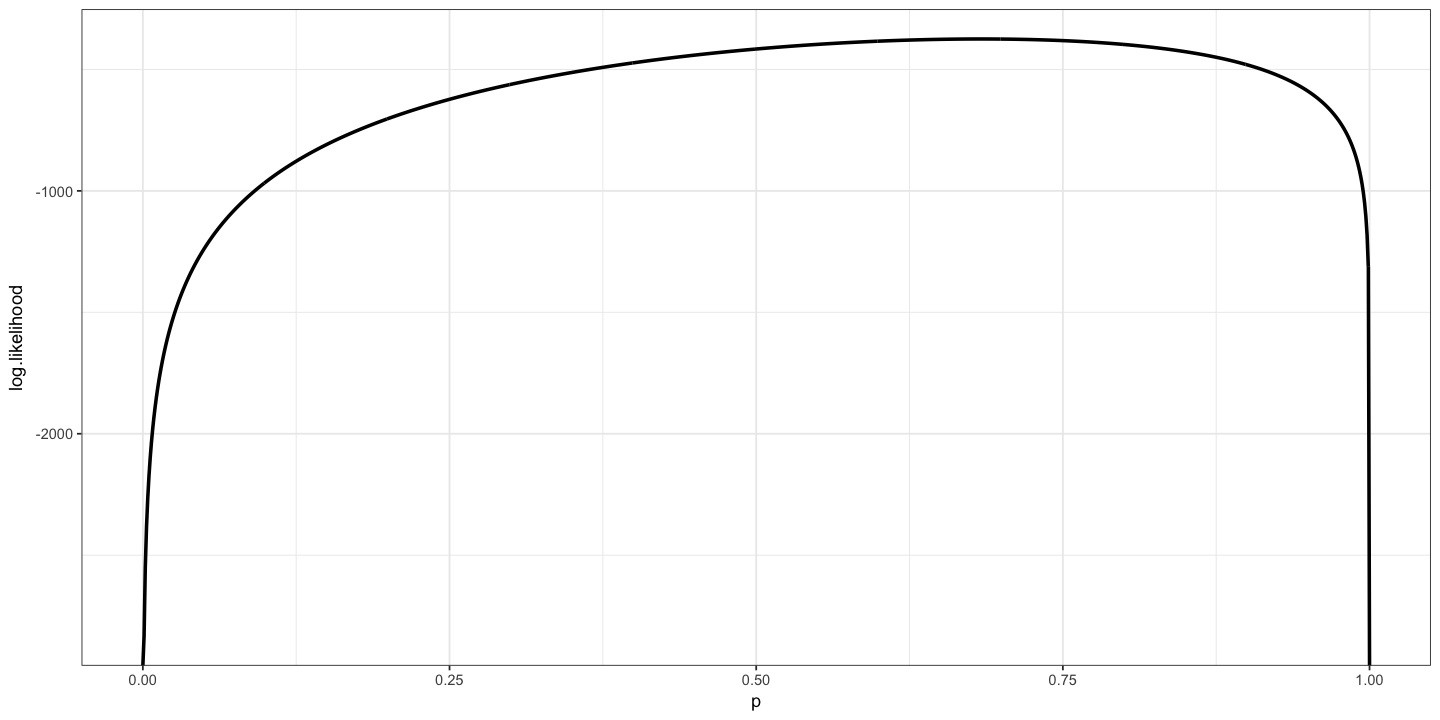

In [13]:
data.frame(p = seq(0, 1, by=0.001)) %>%
    mutate(log.likelihood = loglhood(p, 410, 600)) %>%
    ggplot(aes(x = p, y = log.likelihood)) +
    geom_line(size = 1) +
    scale_fill_manual(values=c("grey20", "grey60")) + 
    theme_bw() +
    theme(legend.position="top", legend.title=element_blank())

Una vez definida la función de verosimilitud, basta con asignar unos valores frontera, junto con el valor inicial, para obtener el óptimo, así como el *hessiano*, a partir del cual aproximaremos la varianza del estimador $\hat{p}_0$.

In [14]:
opt <- optim(runif(1), negative.loglhood,  hessian = TRUE,
             y = sum(coins$hits * coins$freq), m = m,
             lower = 10e-4, upper = 1-10e-4, method = "L-BFGS-B") 

In [15]:
p.zero.hat <- opt$par
p.zero.hat.var <- c(solve(opt$hessian))

In [16]:
display_latex(paste0('$$\\widehat{p}_0 = ', round(p.zero.hat, digits = 5), '\\quad',
                     '\\widehat{Var}[\\widehat{p}_0] = ', round(p.zero.hat.var, digits = 5), '$$'))

Como vemos, estos valores son equivalente a los optenidos mediante el método analítico. Sin embargo, hay muchos casos en que dichos métodos son inescalables cuando el estadístico en cuestión es demasiado complejo de definir.

Una vez hemos calculado el *EMV* bajo la hipótesis nula, ya podemos calcular el las frecuencias esperadas que deberían seguir nuestras observaciones aproximadamente para poder verificar que todas ellas pertenencen a una misma distribución Binomial con parámetro $p_0$.

In [17]:
coins <- coins %>%
    mutate(expected.freq.rel = dbinom(0:6, n(), p.zero.hat))

In [18]:
coins %>% 
    mutate_if(is.numeric, round, digits = 4) %>%
    mutate_all(as.character) %>%
    set_colnames(c('Número de caras', 'Frecuencias', 'Frecuencias Rel.',
                   'Frecuencias Rel. Esperadas')) %>% 
    t() %>% 
    display()

Número de caras,0,1,2,3,4,5,6
Frecuencias,2,8,10,12,16,30,22
Frecuencias Rel.,0.02,0.08,0.1,0.12,0.16,0.3,0.22
Frecuencias Rel. Esperadas,3e-04,0.0048,0.0312,0.1123,0.2423,0.3138,0.2257


El siguiente paso es obtener el estadístico test G. Este se obtiene a partir del test de razón de verosimilitud de la siguiente forma:

Sea:

$$L(p; x_1,..., x_m) \propto  p ^ {\sum x_i} \cdot (1 - p) ^ {m - \sum x_i}$$

Por lo que:


$$logL(p; x_1,..., x_m) \propto  \sum x_i \cdot log(p) +(m - \sum x_i) \cdot log(1 - p)$$

El estadístico test de razón de verosimilitud se puede escribir por tanto como:

\begin{align*}
  RV 
  &=  - 2 \cdot log\left(\Delta(x_1,..., x_m)\right) \\
  &=  - 2 \cdot log\left(\frac{L(\hat{p}_0; x_1,..., x_m)}{L(\hat{p}_{obs}; x_1,..., x_m)}\right) \\
  &=  2 \cdot \left(L(\hat{p}_{obs}; x_1,..., x_m) - L(\hat{p}_{0}; x_1,..., x_m)\right)  \\
  &=  2 \cdot \sum_i y_i \cdot log\left(\frac{\hat{p}_{obs,i}}{\hat{p}_{0,i}}\right) 
\end{align*}

In [19]:
RV <- coins %>%
    summarise(2 * sum(freq.rel * log(freq / expected.freq.rel))) %>%
    pull()

In [20]:
display_latex(paste0('$$RV = ', round(RV, 4), '$$'))

Entonces, para calcular el $pvalor$ del test, basta comparar este estadístico con su distribución bajo $H_0$, en este caso una $\chi^2$ con $7 - 1 = 6$ grados de libertad, ya que el espacio parámetrico de partida es de $7$ valores, mientras que bajo la hipótesis nula, este queda reducido a $1$ único parámetro. Por tanto:

$$pvalor = P(RV \geq \chi_6^2)$$

In [21]:
pvalue <- 1 - pchisq(RV, df=6)

In [22]:
display_latex(paste0('$$pvalor = ', round(pvalue, 4), '$$'))

Tal y como indica el $pvalor$, con una confianza del $95\%$ no tenemos indicios suficientes como para rechazar la hipótesis de que todas las observaciones obtenidas provienen todas ellas de una distribución de $6$ monedas, todas ellas distribuidas de la misma forma (igual tasa de acierto).

A continuación se muestra un gráfico de barras que representa de manera conjunta las frecuencias observadas y esperadas:

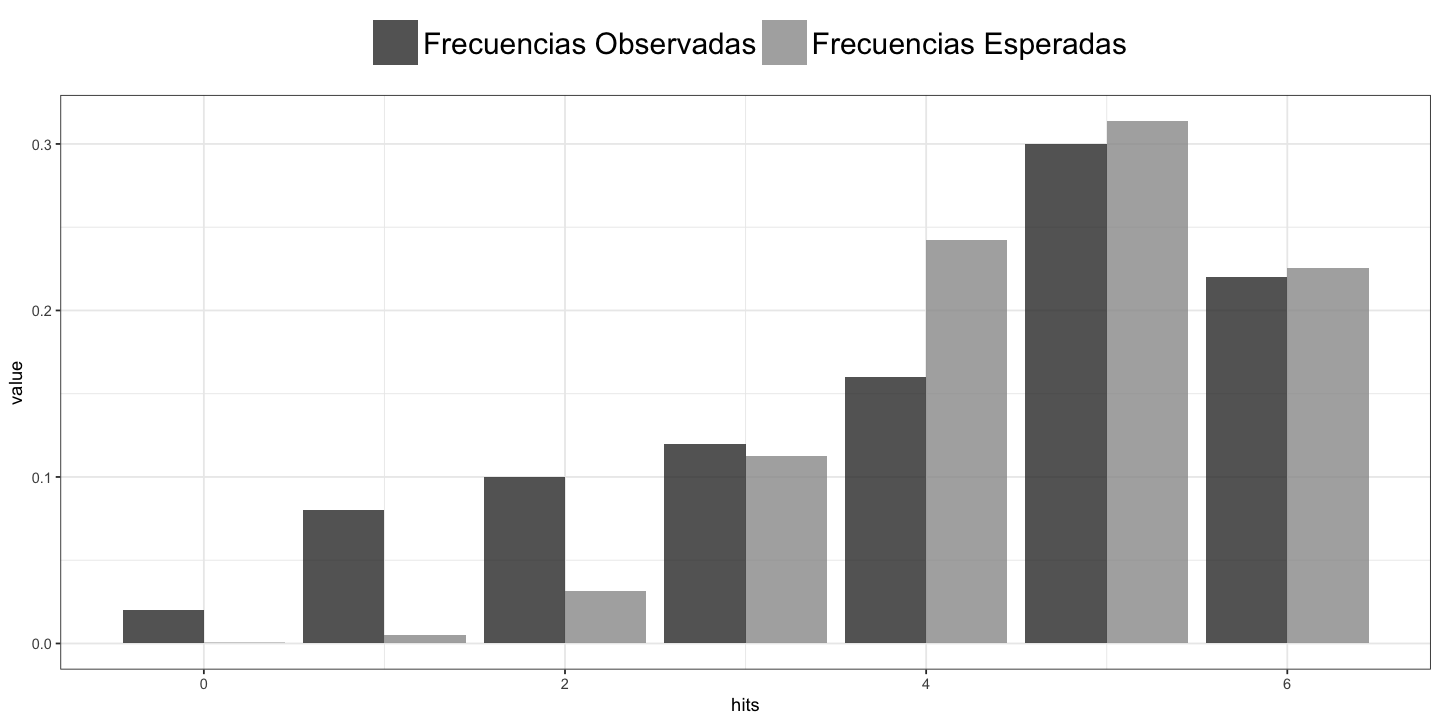

In [23]:
coins %>%
select(hits, freq.rel, expected.freq.rel) %>% 
set_names(c('hits', 'Frecuencias Observadas', 'Frecuencias Esperadas')) %>%
melt(id.vars='hits') %>%
ggplot(aes(x=hits, y=value, fill=variable)) +
    geom_bar(stat='identity', position='dodge', alpha = .8) + 
    scale_fill_manual(values=c("grey20", "grey60")) + 
    theme_bw() +
    theme(legend.position="top", 
          legend.title=element_blank(),
          legend.text=element_text(size=18), 
          legend.key.size = unit(2, 'lines'))


## En el modelo que define la hipótesis nula obtener intervalos de confianza ($95\%$) para el parámetro, basados en los estadísticos de *Wald (W)* y de *razón de verosimilitud (RV)*.

In [24]:
alpha <- 0.05

Ahora vamos a calcular los intervalos de confianza basados en al estimación de *Wald* y en *razón de verosimilitud*. Estos nos proporcionarán un entorno de puntos sobre los cuales el verdadero valor de $p$ se encontrar bajo la hipótesis nula con una probabilidad del $(1 - \alpha) * 100 \%$ Estos intervalos se contruyen de manera diferente, tal y como indicaremos a continuación:

### Intervalo de confianza de Wald:

El Intervalo de confianza basado en inferencias de *Wald* se construye de la siguiente manera. Sabemos que la distribución asintótica estimada es:

\begin{align}
\widehat{p} \ \dot{\sim} \ N\left(p, V(p)\right) \\
\frac{\left(\widehat{p} - p\right)^2}{{V(p)}} \ \dot{\sim} \ \chi^2_1 \\
\end{align}

También sabemos que:
$$\frac{\widehat{p} \cdot(1 - \widehat{p})}{n} \ \rightarrow \ V(p)$$
Luego: 
$$\frac{\left(\widehat{p} - p\right)^2}{\frac{\widehat{p} \cdot \left(1 - \widehat{p}\right)}{n}} = n \cdot \frac{\left(\widehat{p} - p\right)^2}{\widehat{p} \cdot \left(1 - \widehat{p}\right)} \ \dot{\sim} \ \chi^2_1$$

Por tanto, podemos construir un intervalo de confianza basado en los cuantiles de la distribución $\chi^2_1$ aproximada de nivel $1 - \alpha$ de la siguiente manera:
 
$$P_{p_0}\left({p:\chi^2_{1, \alpha/2} \leq n \cdot \frac{\left(\widehat{p} - p\right)^2}{\widehat{p} \cdot \left(1 - \widehat{p}\right)} } \leq \chi^2_{1, 1 - \alpha/2} \right) \approx 1- \alpha$$

Lo cual es equivalente a:
$$P_{p_0}\left({p: Z_{\alpha/2} \leq \frac{\left(\widehat{p} - p\right)^2}{\frac{\widehat{p} \cdot \left(1 - \widehat{p}\right)}{n}} } \leq Z_{1 - \alpha/2} \right) = P_{p_0}\left(p: p \in \left[\widehat{p} \pm Z_{1 - \alpha/2} \cdot \sqrt{\frac{\widehat{p} \cdot \left(1 - \widehat{p}\right)}{n}}\right] \right) \approx 1- \alpha$$

In [25]:
W.IC <- p.zero.hat + c(-1, 1) * qnorm(1 - alpha / 2) * sqrt(p.zero.hat.var)

Por tanto, el intervalo de confianza de *Wald* es el siguiente:

In [26]:
display_latex(paste0('$$\\left[\\widehat{p} \\pm Z_{1 - \\alpha/2} \\cdot \\sqrt{\\frac{\\widehat{p} \\cdot \\left(1 - \\widehat{p}\\right)}{n}}\\right] \\approx \\left(', round(W.IC[1], 5), ', ', round(W.IC[2], 5) , '\\right)$$'))

### Intervalo de confianza de Razón de Verosimilitud:

El intervalo de confianza basasdo en el estadístico de razón de verosimilitud, se basa en la distribución aproximada de dicho estadístico. Sin embargo, en es te caso, no podremos llegar a una ecuación explícita, por lo que para su resolución es necesario recurrir a métodos numéricos. 

Tal y como se ha indicado anteriormente:

$$
  2 \cdot \left(L(p; x_1,..., x_m) - L(\hat{p}_{0}; x_1,..., x_m)\right) \ \dot{\sim} \ \chi^2_1
$$

Por lo tanto, podemos construir un intervalo de nivel $1 - \alpha$ de la siguiente manera:

$$P_{p_0}\left(p:\chi^2_{1, \alpha/2} \leq 2 \cdot \left(L(p; x_1,..., x_m) - L(\hat{p}_{0}; x_1,..., x_m)\right) \leq \chi^2_{1, 1 - \alpha/2} \right) \approx 1- \alpha$$

Lo cual es equivalente a:

$$P_{p_0}\left(p: L(p; x_1,..., x_m) \leq \frac{\chi^2_{1, 1 - \alpha/2}}{2} + L(\hat{p}_{0}; x_1,..., x_m) \right) \approx 1- \alpha$$

In [27]:
Plkhci <- function (x, f, label, prob = 0.95, eps = 0.001, 
                    nmax = 10, nfcn=0, ...) {
    FWithParams=function(x) f(x,...)
    invisible(capture.output(out <- plkhci(control.list, FWithParams, "p")))
    return(out)
}

In [28]:
control.list <- list(label = "p", est = p.zero.hat, low = 0, upp = 1)
LR.ci <- Plkhci(control.list, negative.loglhood, "p", 
                prob = 0.95, y = 410, m=600)

Por tanto, el intervalo de confianza de *razón de verosimilitud* es el siguiente:

In [29]:
display_latex(paste0('$$\\left[L(p; x_1,..., x_m) \\leq \\frac{\\chi^2_{1, 1 - \\alpha/2}}{2} + L(\\hat{p}_{0}; x_1,..., x_m) \\right] \\approx \\left(', round(LR.ci[1], 5), ', ', round(LR.ci[2], 5) , '\\right)$$'))

In [30]:
coins.test <- data.frame(p = seq(0, 1, by=0.002)) %>%
    mutate(LR  = - 2 * (loglhood(p, 410, 600)
                        - loglhood(p.zero.hat, 410, 600)),
           W   = (p - p.zero.hat) ^ 2 / c(p.zero.hat.var),
           chi = sqrt(qchisq(1 - alpha / 2, df = 6))
    )

A continuación se muestra un gráfico a través del cual se pueden apreciar los distintos valores que toman los estadísticos de *Wald* y *razón de verosimilitud* con $p$ como soporte. Además, se muestra la región crítica a partir de la cual es necesario rechazar a nivel $\alpha = 0.05$. Como vemos, los valores para *RV* están dentro del intervalo $[0, 1]$, mientras que para el caso de *Wald* estos toman valores imposibles.

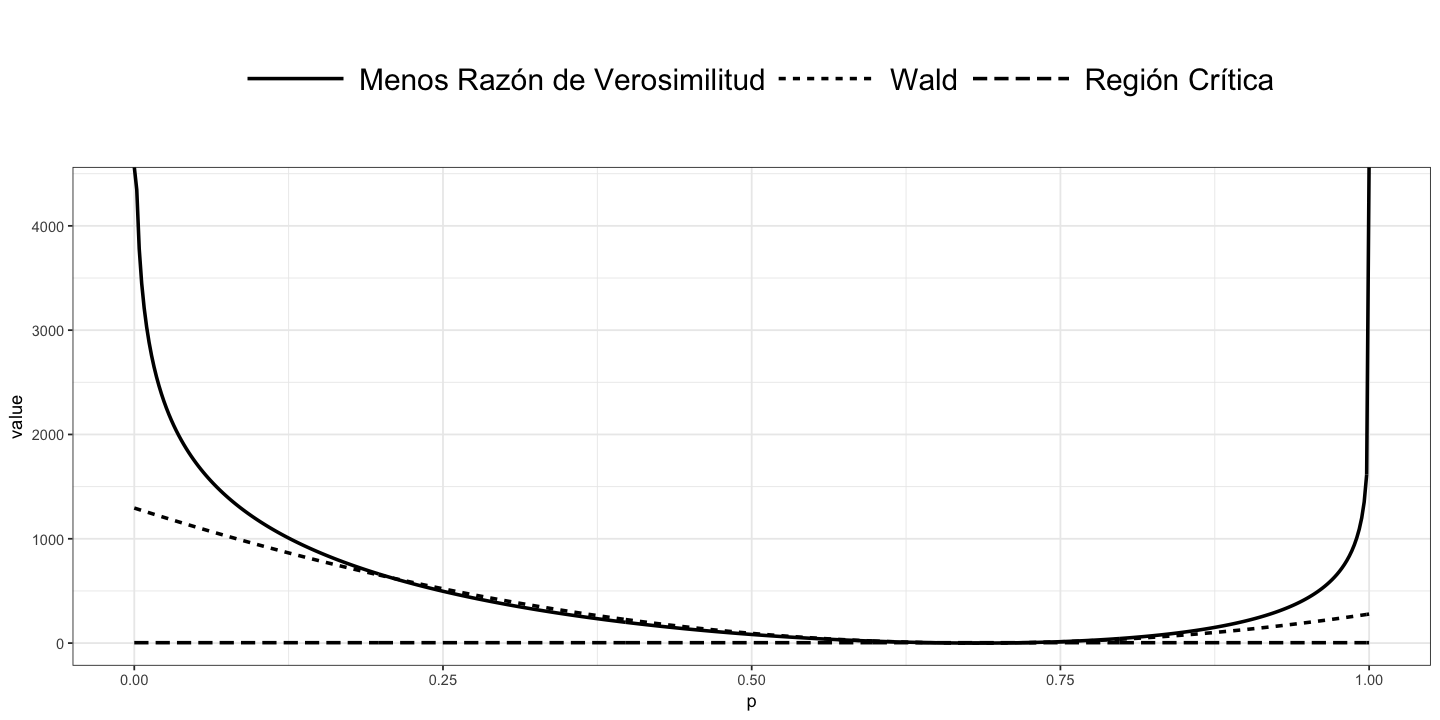

In [31]:
coins.test %>%
    set_colnames(c("p", "Menos Razón de Verosimilitud", "Wald", "Región Crítica")) %>%
    melt(id.vars='p') %>%
    ggplot(aes(x = p, y = value, linetype = variable)) +
    geom_line(size = 1) +
    theme_bw() +
    theme(legend.position="top", 
          legend.title=element_blank(),
          legend.text=element_text(size=18), 
          legend.key.size = unit(5, 'lines'))

La siguiente imagen muestra el mismo gráfico que la anterior. Sin embargo, en este caso se ha ampliado la zona cercana al *EMV* bajo la hipótesis nula, de tal manera que se puede apreciar la diferencia que se ve reflejada en los límites de los correspondientes intervalos de confianza para cada estadístico.

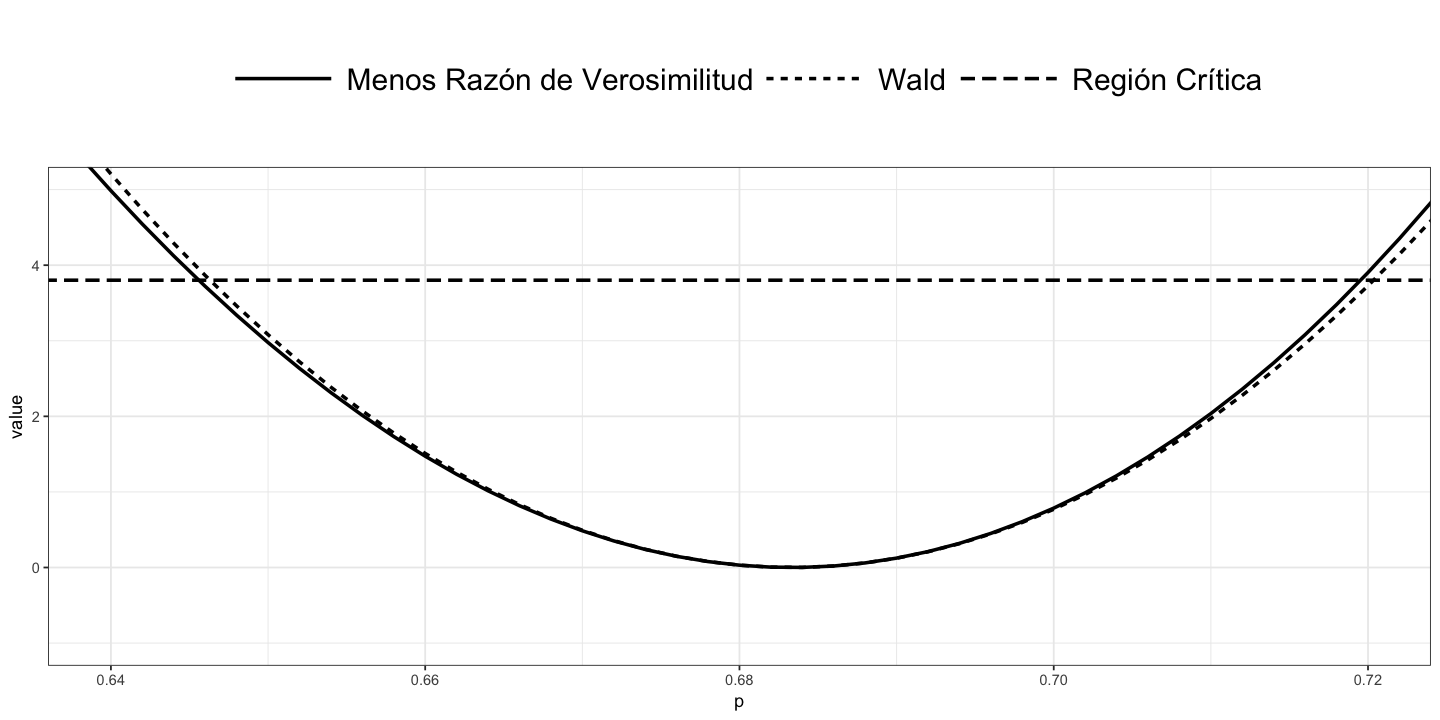

In [32]:
coins.test %>%
    set_colnames(c("p", "Menos Razón de Verosimilitud", "Wald", "Región Crítica")) %>%
    melt(id.vars='p') %>%
    ggplot(aes(x = p, y = value, linetype = variable)) +
    geom_line(size = 1) +
    coord_cartesian(xlim=c(0.64, 0.72), ylim=c(-1, 5)) +
    theme_bw() +
    theme(legend.position="top", 
          legend.title=element_blank(),
          legend.text=element_text(size=18), 
          legend.key.size = unit(5, 'lines'))

# Considerar el vector aleatorio $X = (X_1, ..., X_5)$ 

Supongamos que $X$ (vector aleatorio de datos completos) se distribuye sobre una distribución multinomial, tal que:

$$X = (X_1, X_2, X_3, X_4, X_5) \sim multinomial\left(n, \left(\frac{1}{2}, \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}\right)\right)$$

La función de verosimilitud en este caso será:

\begin{align*}
  L(\theta; x_1,..., x_5) 
  &= \left(\frac{1}{2}\right) ^ {x_1} \cdot \left(\frac{\theta}{4}\right) ^ {x_2} \cdot \left(\frac{1 - \theta}{4}\right) ^ {x_3} \cdot \left(\frac{1 - \theta}{4}\right) ^ {x_4} \cdot \left(\frac{\theta}{4}\right) ^ {x_5} \\
   &\propto  \left(\frac{\theta}{4}\right) ^ {x_2} \cdot \left(\frac{1 - \theta}{4}\right) ^ {x_3} \cdot \left(\frac{1 - \theta}{4}\right) ^ {x_4} \cdot \left(\frac{\theta}{4}\right) ^ {x_5} \\
  &=  \left(\frac{\theta}{4}\right) ^ {x_2 + x_4} \cdot \left(\frac{1 - \theta}{4}\right) ^ {x_3 +x_5} \\
  &\propto  \theta ^ {x_2 + x_5} \cdot \left(1 - \theta\right) ^ {x_3 +x_4} 
\end{align*}

Por lo que:

$$logL(\theta; x_1,..., x_5) \propto \left(x_2 + x_5\right) \cdot log\left(\theta\right) + \left(x_3 + x_4\right) \cdot log\left(1- \theta\right)
$$

Se define $Y$ (vector de datos observados o incompletos) a partir de $X$ como:

\begin{align*}
  Y 
  &= (Y_1, Y_2, Y_3, Y_4) \\
  &= (X_1 + X_2, X_3, X_4, X_5) \sim multinomial\left(n, \left(\frac{1}{2}+ \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}\right)\right)
\end{align*}

La función de verosimilitud en este caso será:

\begin{align*}
  L(\theta; y_1,..., y_4) 
  &= L(p; x_1 +x_2, x_3, x_4, x_5) \\
  &= \left(\frac{1}{2} + \frac{\theta}{4}\right) ^ {y_1} \cdot \left(\frac{1 - \theta}{4}\right) ^ {y_2} \cdot \left(\frac{1 - \theta}{4}\right) ^ {y_3} \cdot \left(\frac{\theta}{4}\right) ^ {y_4} \\
  &=  \left(\frac{1}{2} + \frac{\theta}{4}\right) ^ {y_1} \cdot \left(\frac{1 - \theta}{4}\right) ^ {y_2 + y_3} \left(\frac{\theta}{4}\right) ^ {y_4} \\
  & \propto  \left(2 + \theta\right) ^ {y_1} \cdot \left(1 - \theta\right) ^ {y_2 + y_3} \cdot \theta ^ {y_4}
\end{align*}

Por lo que a función de verosimilitud será:

$$
logL(\theta; y_1,..., y_4) = \left(y_1\right) \cdot log\left(2 + \theta\right) + \left(y_2 + y_3\right) \cdot log\left(1- \theta\right) + \left(y_4\right) \cdot log\left(\theta\right) 
$$

Si intentamos reescribir la función de verosimilitud de $X$ en función de $Y$ tenemos que:

\begin{align*}
logL(\theta; x_1, x_2,y_2,y_3,y_4) \propto (x_2 + y_4) \cdot log(\theta) + (y_2 + y_3) \cdot log(1 - \theta)
\end{align*}

Ahora necesitamos calcular la esperanza de la función de log verosimilitud conjunta:

\begin{align*}
E_{\theta^{(0)}}\left[X \mid Y = y \right] &= E\left[(X_2 + X_5) \cdot log(\theta) + (X_3 + X_4) \cdot log(1- \theta) \mid Y = y \right] \\ 
&= (E\left[X_2 | Y_1 = y_1 \right] + y_4) \cdot log(\theta) + (y_2 + y_3) \cdot log(1- \theta) \\
&= \left(\frac{\frac{\theta}{4}}{\frac{1}{2} + \frac{\theta}{4}} \cdot y_1 + y_4 \right) \cdot log(\theta) + (y_2 + y_3) \cdot log(1- \theta) \\
&= \left(\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4\right) \cdot log(\theta) + (y_2 + y_3) \cdot log(1 - \theta)
\end{align*}


Por último, es necesario maximizar dicho valor. Para ello tomaremos derivadas, igualaremos a cero y despejaremos el parámetro $\theta$:

\begin{align*}
\frac{\partial}{\partial\theta} E_{\theta^{(0)}}\left[ X \mid Y = y \right]
&= \frac{\partial}{\partial\theta} \left(\left(\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4\right) \cdot log(\theta) + (y_2 + y_3) \cdot log(1 - \theta) \right) \\
&= \frac{\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4}{\theta}+ \frac{-(y_2 + y_3)}{1 - \theta}
\end{align*}

Ahora despejámos el parámetro $\theta$ para llegar a una ecuación explícita:

\begin{align*}
0 &= \frac{\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4}{\theta}+ \frac{-(y_2 + y_3)}{1 - \theta} \\
\frac{y_2 + y_3}{1 - \theta} &=  \frac{\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4}{\theta} \\
\theta \cdot\left(\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4 + y_2 + y_3 \right) &=\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4 \\
\theta &= \frac{\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4}{\frac{\theta^{(0)}}{2 + \theta^{(0)}} \cdot y_1  + y_4 + y_2 + y_3}
\end{align*} 

In [33]:
update.theta <- function(theta, y) {
    temp <- (theta * y[1]) / (2 + theta)
    theta <- (temp + y[4]) / (temp + y[2] + y[3] + y[4])
    return(theta)
}

Ahora pondremos en práctica el algoritmo EM. Se observa:
$$y = \left(125, 18, 20, 34\right)$$

Se pide aproximar el estimador máximo verosímil de $\theta$, utilizando $3$ iteraciones del *algoritmo EM*, partiendo del valor inicial $\theta^{(0)} = 0.5$.

In [34]:
y <- c(125, 18, 20, 24)
theta.zero <- 0.5
iterations <- 3

Por tanto, ejecutamos el algoritmo:

In [35]:
theta <- rep(0, iterations + 1)
theta[1] <- runif(1)
for (i in 1:iterations + 1) {
    theta[i] <- update.theta(theta[i - 1], y)
}

Tras 3 ejecuciones del algoritmo, los resultados son los siguientes:

In [36]:
for (i in 1:(iterations + 1)) {
    display_latex(paste0('$$\\widehat{\\theta}^{(', i - 1, ')} = ', round(theta[i], 4), '$$'))
}